In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
%matplotlib inline

                               Open      High       Low     Close  Volume  \
Date                                                                        
1977-01-03 00:00:00-05:00  6.955804  7.000536  6.955804  7.000536   47952   
1977-01-04 00:00:00-05:00  7.000539  7.022904  6.978172  7.022904   34217   
1977-01-05 00:00:00-05:00  7.022904  7.022904  6.955806  6.978172   15422   
1977-01-06 00:00:00-05:00  6.955810  6.955810  6.866346  6.933444   39036   

                           Dividends  Stock Splits  
Date                                                
1977-01-03 00:00:00-05:00        0.0           0.0  
1977-01-04 00:00:00-05:00        0.0           0.0  
1977-01-05 00:00:00-05:00        0.0           0.0  
1977-01-06 00:00:00-05:00        0.0           0.0  


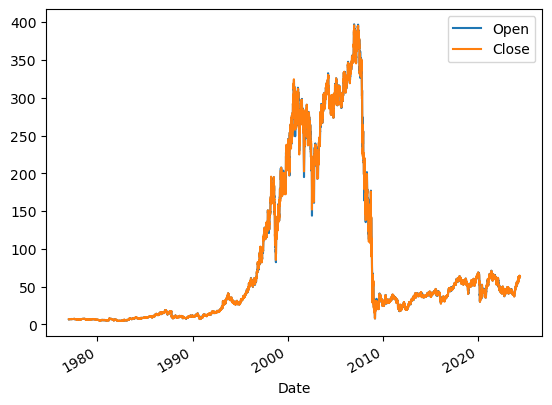

In [37]:
# Yahoo Finance has a nice API
import yfinance as yahooFinance
# GetInformation = yahooFinance.Ticker("^IXIC")
# GetInformation = yahooFinance.Ticker("MSFT")
GetInformation = yahooFinance.Ticker("C")
df = GetInformation.history(period="max")
print(df.head(4))
df.plot(y=['Open','Close'])
plt.show()

In [38]:
def create_time_windows(df, n_window ,n_forecast, scale=True ): 
    '''
        This creates a rolling time window (X,y) from the Pandas DataFrame df, and store it in a numpy array of size (nsamples, n_window/n_forecast, nfeatures)
        n_features referr to open/close/volume etc, while also going through a min-max scaler from -1 to 1 for all time windows
    '''
    N, N_features = len(df), len(list(df))
    X, y = [], []
    sc = MinMaxScaler(feature_range=(0,1))
    df1 = sc.fit_transform(df)
    for i in range(n_window,N-n_forecast):
        tmp = df1[(i-n_window):(i+n_forecast),...]
        if scale:
            tmp = sc.fit_transform(tmp)
        X.append(tmp[:n_window,...])
        y.append(tmp[n_window:,...])
        
    return np.array(X), np.array(y)

In [39]:
n_window, n_forecast = 8*5, 1
df1 = pd.DataFrame({'Return':df['Close']})
# use MaxAbsScaler, therefore preserving 0 to be the zero return. 
X, y = create_time_windows(df1, n_window = n_window, n_forecast = n_forecast, scale=False)

Nsamples = X.shape[0]
Ntrain = int(Nsamples * 0.8) 
Xtrain, ytrain = X[:Ntrain,...], y[:Ntrain,...]
Xtest, ytest = X[Ntrain:,...], y[Ntrain:,...]



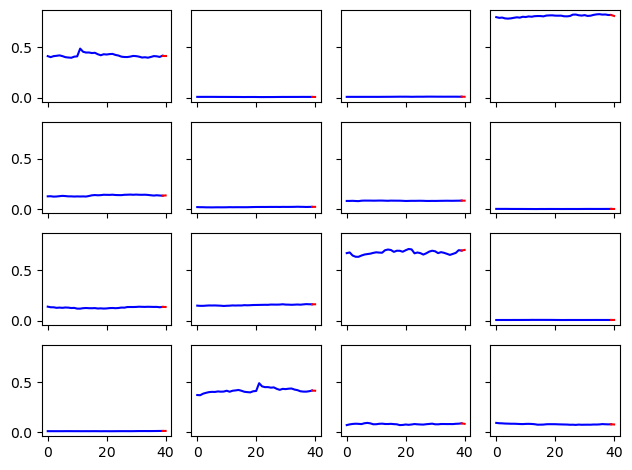

In [40]:
fig, ax = plt.subplots(4,4,sharex=True,sharey=True)
samples = [[np.random.randint(0,X.shape[0]) for _ in range(4)] for _ in range(4)]
for r in range(4):
    for c in range(4):
        idx= samples[r][c]
        ax[r,c].plot(range(n_window),X[idx,:,0],"b-")
        ax[r,c].plot(range(n_window-1,n_window+n_forecast),np.concatenate([X[idx,-1:,0],y[idx,:,0]]),"r-")
plt.tight_layout()
plt.show()
plt.close()

In [41]:
nfeatures = 1 # only use first nfeature columns for training and prediction
model5= keras.Sequential([keras.Input(shape=(None,nfeatures)),
                          keras.layers.LSTM(64,return_sequences=False),
                          keras.layers.Dense(n_forecast)])
model5.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='mse')
ntrain = int(Xtrain.shape[0]*0.8)
history = model5.fit(Xtrain[:ntrain,:,:nfeatures],ytrain[:ntrain,:,0], batch_size= 32,
                     epochs = 100,validation_data=(Xtrain[ntrain:,:,:nfeatures],ytrain[ntrain:,:,0]))
# model5.save('models/Classification_SimpleRNN_Return_NextDay_May28_920PM.keras')

Epoch 1/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0073 - val_loss: 2.8837e-04
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.8614e-04 - val_loss: 2.7479e-04
Epoch 3/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.6413e-04 - val_loss: 2.8033e-04
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.4018e-04 - val_loss: 2.2105e-04
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.4597e-04 - val_loss: 2.3680e-04
Epoch 6/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.4247e-04 - val_loss: 2.5977e-04
Epoch 7/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.1719e-04 - val_loss: 1.8974e-04
Epoch 8/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.1692e-04 - val_loss: 2.0071e-04
Epoch 9/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.1629e-04 - val_loss: 2.5415e-04
Epoch 10/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.0585e-04 - val_loss: 1.7068e-04
Epoch 11/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

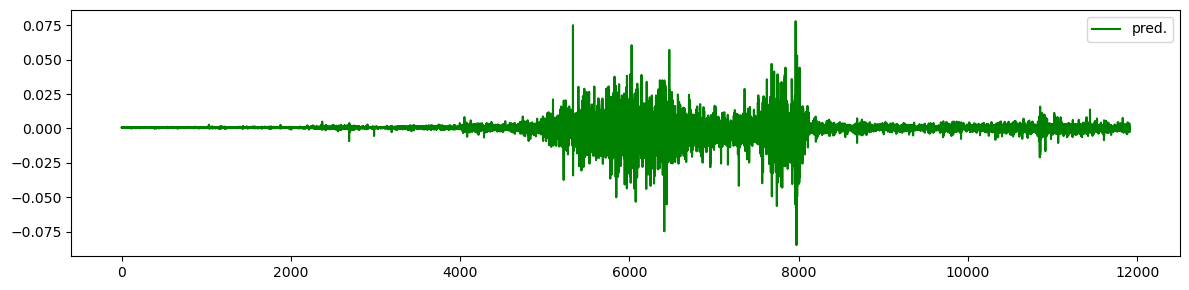

In [44]:
# plot predictions based on model 2
def plot_forecast(X,y,model):
    # only do this for the test data set! 
    ypred = model(X[:,:,:1])
    fig = plt.figure(figsize=(12,3))
    # plt.plot(y[:,0,0],"r-",label="actual")
    # plt.plot(ypred[:,0],"g-",label="pred.")
    plt.plot(y[:,0,0]-ypred[:,0],"g-",label="pred.")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close(fig)
plot_forecast(X,y,model=model5)

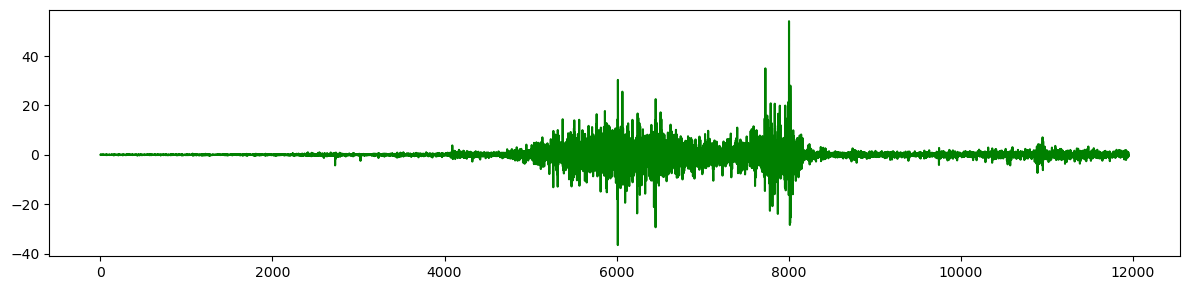

In [43]:
fig = plt.figure(figsize=(12,3))
plt.plot(range(len(df)),df['Open'].diff(),"g-")
plt.tight_layout()
plt.show()
plt.close(fig)

# LSTM 
- prediction looks like a lagged version of actual result

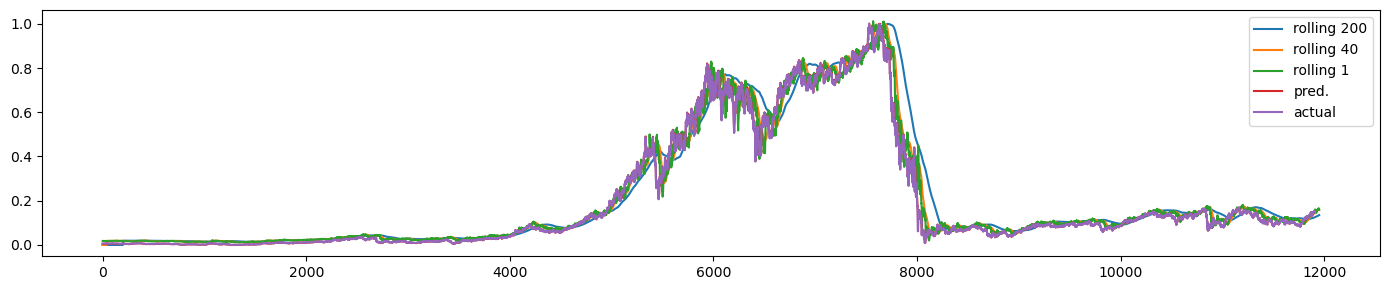

In [80]:
# plot predictions based on model 2
def plot_forecastv1(X,y,model):
    # only do this for the test data set! 
    ypred = model(X[:,:,:1])
    
    fig = plt.figure(figsize=(14,3))
    for days in [200,40,1]:
        tmp = df1.rolling(days).mean().fillna(0).to_numpy()
        tmp = tmp / (tmp.max()-tmp.min())
        plt.plot(tmp,"-",label=f"rolling {days}",ms=0.5,markeredgecolor=None)
    

    plt.plot(ypred[:,0],"-",label="pred.")
    plt.plot(y[:,0,0],"-",label="actual")
    # plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close(fig)
plot_forecastv1(X,y,model=model5)